# Notebook 03 - Data Cleaning

## Objectives
* Clean data
* Evaluate and process missing data

## Inputs
* outputs/datasets/collection/HousePricesRecords.csv

## Outputs
* Create Clean dataset:
    * all new datasets of cleaning will be stored in inputs/datasets/cleaning
* Split created dataset in to 2 parts:
    * Train
    * Test
* all new datasets (train and test) will be stored in outputs/datasets/cleaned

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,0,856,854.0,3.0,No,706,GLQ,150,0.0,548,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,3,961,NaN,NaN,No,216,ALQ,540,NaN,642,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


Will make a copy of dataset, so later it can be compared with cleaned one

## Exploring Data

We will get all features that are missing data as a list

In [5]:
features_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
features_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

### Visualizing Missing Data

Visualize the missing data to better understand the pattern of missing values.

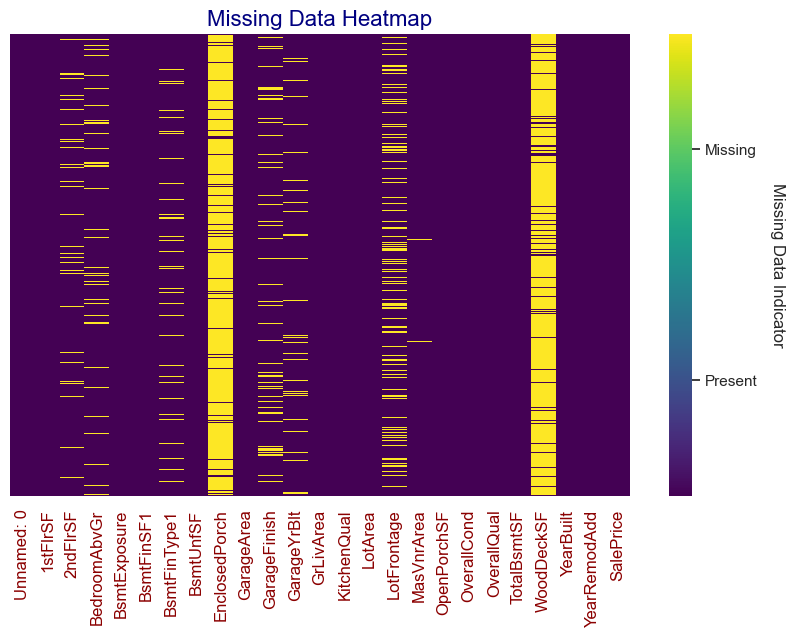

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the background style
sns.set(style="white")

# Prepare the data for heatmap, converting True/False to integers for color mapping
heatmap_data = df.isnull().astype(int)

# Visualize missing values as a heatmap
plt.figure(figsize=(10, 6))
# Using `cbar=True` to show the color bar
ax = sns.heatmap(heatmap_data, yticklabels=False, cbar=True, cmap='viridis',
                 cbar_kws={'label': 'Missing Data Indicator'})

# Customize the plot with titles and labels as needed
plt.title('Missing Data Heatmap', fontsize=16, color='navy')
plt.xticks(fontsize=12, color='darkred')  # Set x-tick colors to dark red
plt.yticks(fontsize=12, color='darkred')  # Set y-tick colors to dark red

# Set color bar label and style
cbar = ax.collections[0].colorbar
cbar.set_label('Missing Data Indicator', rotation=270, labelpad=20)
cbar.set_ticks([0.25, 0.75])  # Setting tick positions
cbar.set_ticklabels(['Present', 'Missing'])  # Setting tick labels

# Show the plot
plt.show()


We will generate a profiling report for features with missing data, which will assist us in selecting the most effective method for data cleaning.

In [7]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df=df[features_with_missing_data], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## All Data Cleaning

All Data cleaning with all steps, graphs, etc. will be performed in folder jupyter_notebooks/data_cleaning/

* All this is because we have noticed quite a few missing data vales, also we need to perform more deep checking on data is it all correct and valid.
* After All cleaning and fixing data in folder jupyter_notebooks/data_cleaning is completed, we will import inputs/datasets/cleaning/clean_finished.csv as current dataframe

When jupyter_notebooks/data_cleaning is being processed, we will add cleaning code below

In [8]:
df.loc[:, 'LotFrontage'] = df['LotFrontage'].fillna(70)

# Lists of columns grouped by their fill values and type conversions
fill_zero_and_convert = ['1stFlrSF', '2ndFlrSF', 'GarageArea', 'GarageYrBlt',
                         'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF', 'BedroomAbvGr']
fill_none = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish']

# Fill missing values with zero and convert to integers for numerical columns
df[fill_zero_and_convert] = df[fill_zero_and_convert].fillna(0).astype(int)

# Fill missing values with 'None' for categorical columns
df[fill_none] = df[fill_none].fillna('None')
df['LotFrontage'] = df['LotFrontage'].round().astype(int)

df.loc[df['2ndFlrSF'] == 0, 'BedroomAbvGr'] = df['BedroomAbvGr'].replace(0, 2)
df.loc[df['2ndFlrSF'] > 0, 'BedroomAbvGr'] = df['BedroomAbvGr'].replace(0, 3)

# Swap values where '2ndFlrSF' is greater than '1stFlrSF'
swap_idx = df['2ndFlrSF'] > df['1stFlrSF']
df.loc[swap_idx, ['1stFlrSF', '2ndFlrSF']] = df.loc[swap_idx, ['2ndFlrSF', '1stFlrSF']].values

# Define features and their 'no presence' values
basement_features = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']
features_and_values = {"BsmtExposure": "None", "BsmtFinType1": "None", "BsmtFinSF1": 0, "BsmtUnfSF": 0,
                       "TotalBsmtSF": 0}

# Check and update inconsistencies for each feature
for feature in basement_features:
    primary_value = features_and_values[feature]
    df['Consistency'] = df.apply(
        lambda row: all(row[f] == v for f, v in features_and_values.items()) if row[feature] == primary_value else True,
        axis=1
    )
    inconsistent_idx = df[~df['Consistency']].index
    if feature in ['BsmtExposure', 'BsmtFinType1']:
        correction = 'No' if feature == 'BsmtExposure' else 'Unf'
        df.loc[inconsistent_idx, feature] = correction

# Dropping new created column Consistency
df = df.drop(columns = ['Consistency'])

# Correct zero values and adjust inconsistent records using vectorized operations
df.loc[df['BsmtUnfSF'] == 0, 'BsmtUnfSF'] = df['TotalBsmtSF'] - df['BsmtFinSF1']
df.loc[df['BsmtFinSF1'] == 0, 'BsmtFinSF1'] = df['TotalBsmtSF'] - df['BsmtUnfSF']
df.loc[df['TotalBsmtSF'] == 0, 'TotalBsmtSF'] = df['BsmtUnfSF'] + df['BsmtFinSF1']

# Identify and adjust records with inconsistent basement measurements using a ratio (example: 3)
mask = df['BsmtFinSF1'] + df['BsmtUnfSF'] != df['TotalBsmtSF']
df.loc[mask, 'BsmtUnfSF'] = (df.loc[mask, 'TotalBsmtSF'] / 3).astype(int)
df.loc[mask, 'BsmtFinSF1'] = df.loc[mask, 'TotalBsmtSF'] - df.loc[mask, 'BsmtUnfSF']

# Define a dictionary for checking consistency based on 'GarageFinish'
features_and_values = {"GarageArea": 0, "GarageFinish": 'None', "GarageYrBlt": 0}


def check_consistency(df, primary_feature):
    primary_value = features_and_values[primary_feature]
    return df.apply(
        lambda row: all(row[feature] == value for feature, value in features_and_values.items())
        if row[primary_feature] == primary_value else True, axis=1
    )


# Apply consistency check and correct 'GarageFinish'
consistency_mask = check_consistency(df, 'GarageFinish')
df.loc[~consistency_mask, 'GarageFinish'] = 'Unf'

# Correct garage years that are earlier than the house build year
df.loc[df['GarageYrBlt'] < df['YearBuilt'], 'GarageYrBlt'] = df['YearBuilt']


During cleaning, we did not drop any features, even some of them were missing nearly 90% of data.
We keep them to explore any potential correlations.

## Splitting data to train and test

In [9]:
import os
from sklearn.model_selection import train_test_split

# Ensure output directories exist
output_dir = 'outputs/datasets/cleaned'
os.makedirs(output_dir, exist_ok=True)  # Creates the directory if it does not exist

# No need to separate features and target just yet, keep the dataframe whole for the split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [10]:
# Save the datasets to PARQUET files including 'SalePrice'
df_train.to_parquet(f'{output_dir}/train.parquet.gzip', compression='gzip')
df_test.to_parquet(f'{output_dir}/test.parquet.gzip', compression='gzip')

In [11]:
# Before we start plotting, we need to drop 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

## Correlation Study

### Initial study of correlations between features

Before we start checking correlations, we need to 

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  600.0  0.046  0.097  0.0  0.0  0.0  0.049  0.719


* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi collinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



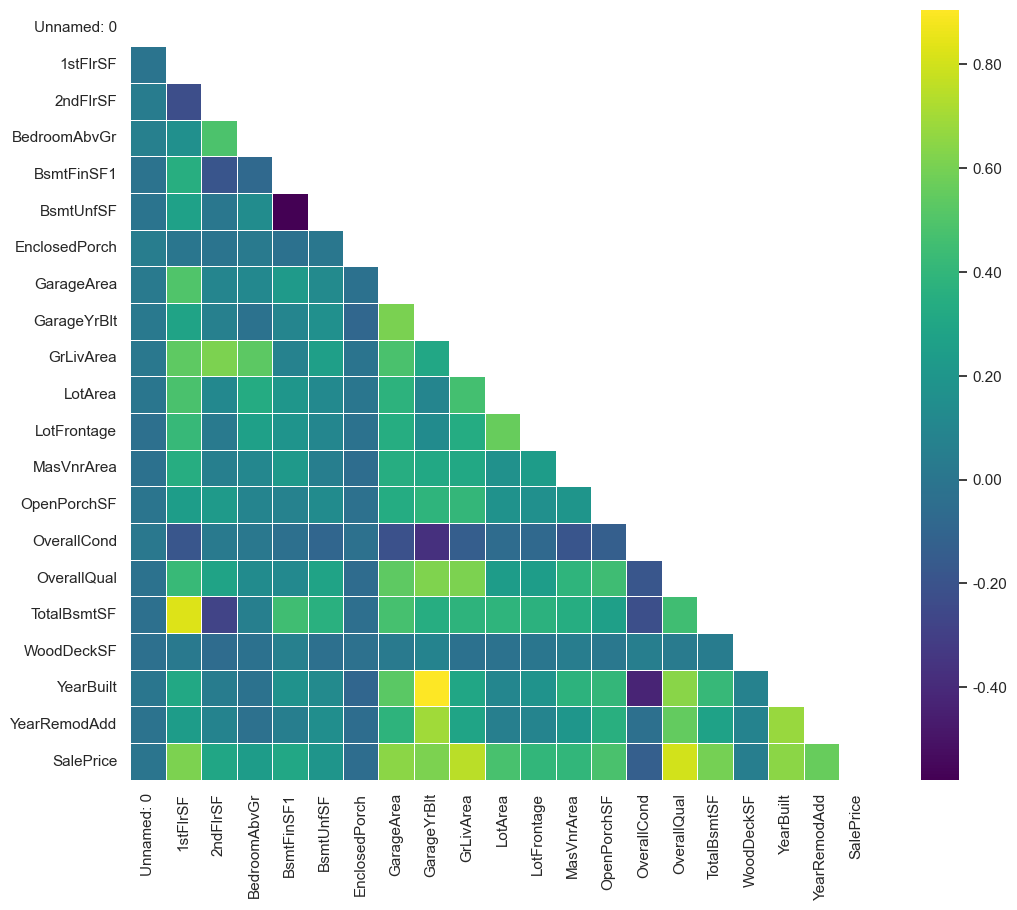



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



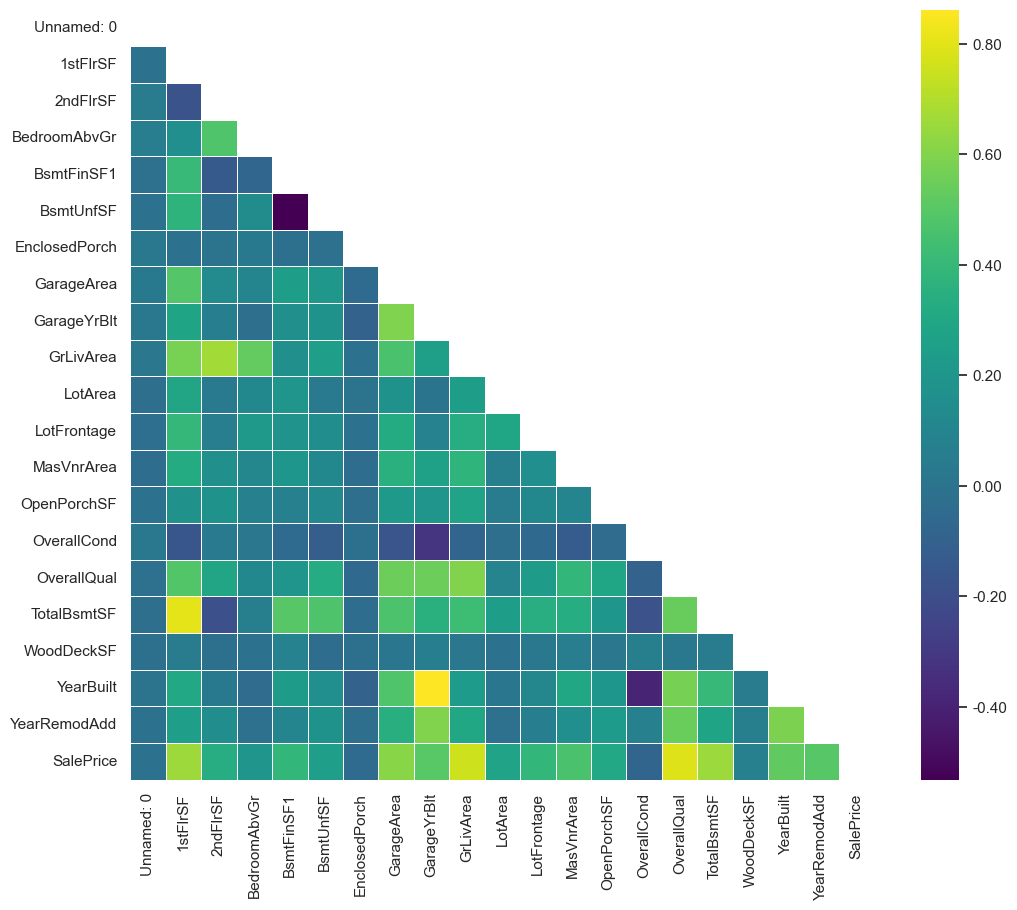



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



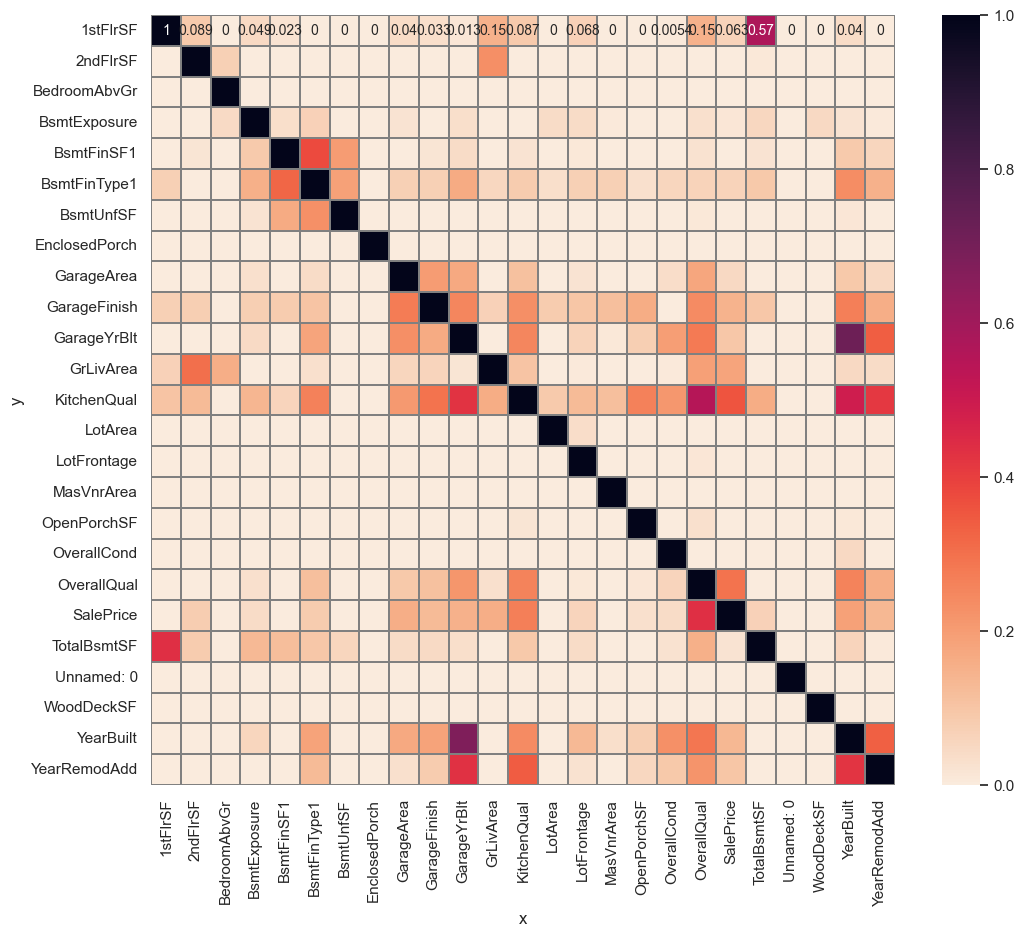

In [12]:
%matplotlib inline
import numpy as np


def format_annotation(val, fmt="{:.2f}"):
    """
    Custom function to format the annotation, ensuring that formatting is only applied to non-masked values.
    Returns formatted string or empty string if the value is NaN.
    """
    return fmt.format(val) if not np.isnan(val) else ''


import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

# Other function definitions remain the same

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    """
    Generates a correlation heatmap using seaborn with optional annotations.
    """
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5, fmt="",  # Removed fmt and applied custom annotation
                    cbar_kws={"format": plt.FuncFormatter(lambda x, pos: format_annotation(x))})
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    """
    Generates a Power Predictive Score (PPS) heatmap using seaborn.

    Parameters:
        df (DataFrame): DataFrame containing PPS values.
        threshold (float): Threshold value to mask the PPS scores for better visibility.
        figsize (tuple): Dimensions of the figure.
        font_annot (int): Font size for annotations.
    """
    if len(df.columns) > 1:
        # Create a mask for values below threshold
        mask = np.zeros_like(df, dtype=bool)
        mask[np.abs(df) < threshold] = False

        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                    linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def calculate_corr_and_pps(df):
    """
    Calculates both Pearson and Spearman correlations and Power Predictive Scores for the given DataFrame.

    Parameters:
        df (DataFrame): Input data.

    Returns:
        Tuple: Contains DataFrames for Pearson correlation, Spearman correlation, and PPS matrix.
    """
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def display_corr_and_pps(df_corr_pearson, df_corr_spearman, pps_matrix, corr_threshold, pps_threshold,
                         figsize=(20, 12), font_annot=8):
    """
    Displays correlation and PPS heatmaps for analysis.

    Parameters:
        df_corr_pearson (DataFrame): Pearson correlation DataFrame.
        df_corr_spearman (DataFrame): Spearman correlation DataFrame.
        pps_matrix (DataFrame): PPS matrix DataFrame.
        corr_threshold (float): Threshold for correlation masking.
        pps_threshold (float): Threshold for PPS masking.
        figsize (tuple): Dimensions of the figure.
        font_annot (int): Font size for annotations.
    """
    print("\n")
    print(
        "* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyze multi collinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=corr_threshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=corr_threshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=pps_threshold, figsize=figsize, font_annot=font_annot)


df_corr_pearson, df_corr_spearman, pps_matrix = calculate_corr_and_pps(df_train)

display_corr_and_pps(df_corr_pearson=df_corr_pearson,
                     df_corr_spearman=df_corr_spearman,
                     pps_matrix=pps_matrix,
                     corr_threshold=0.01, pps_threshold=0.01,
                     figsize=(12, 10), font_annot=10)


We will explore correlation (pearson and spearman methods) of Sales Price and all the rest features, sort values by absolute value and see most correlated features
Before we process to correlation, all data objects needs to be encoded

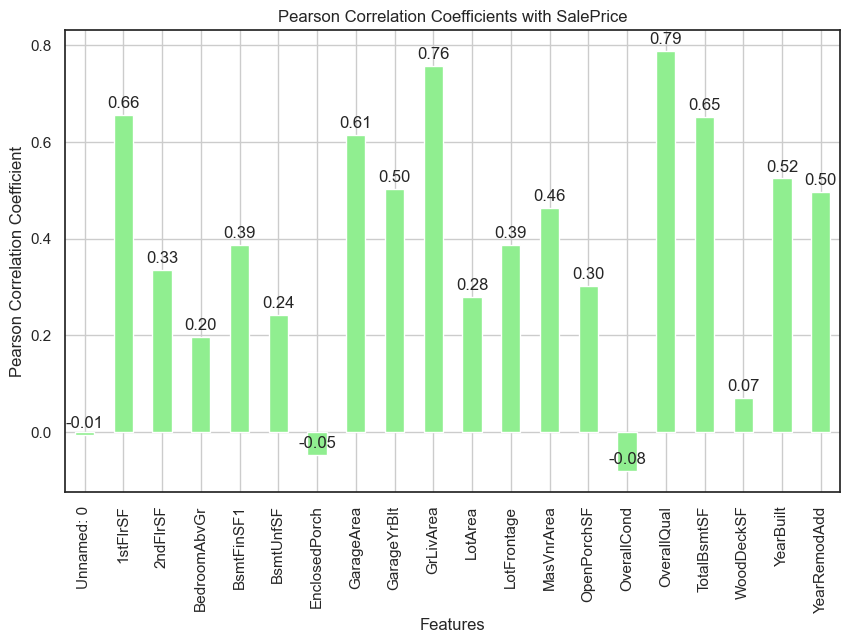

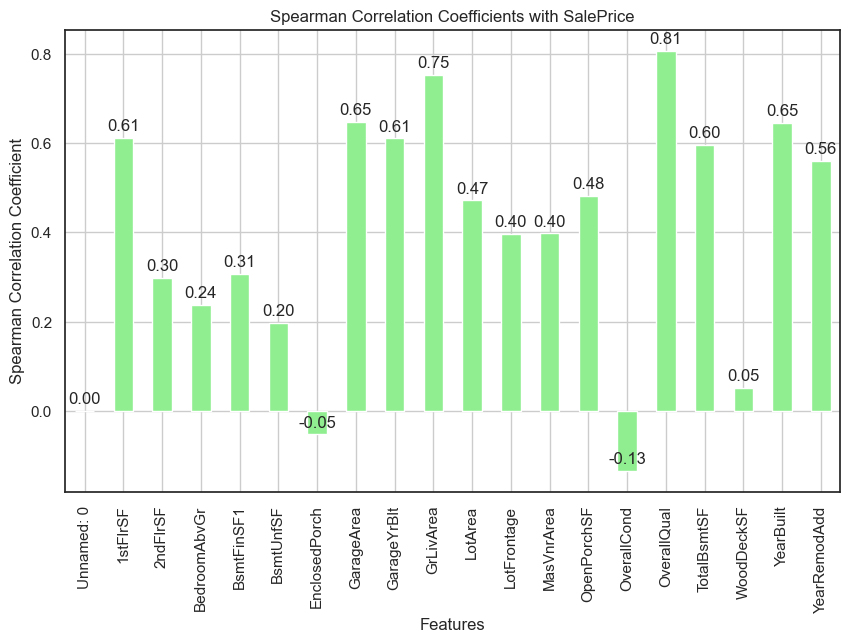

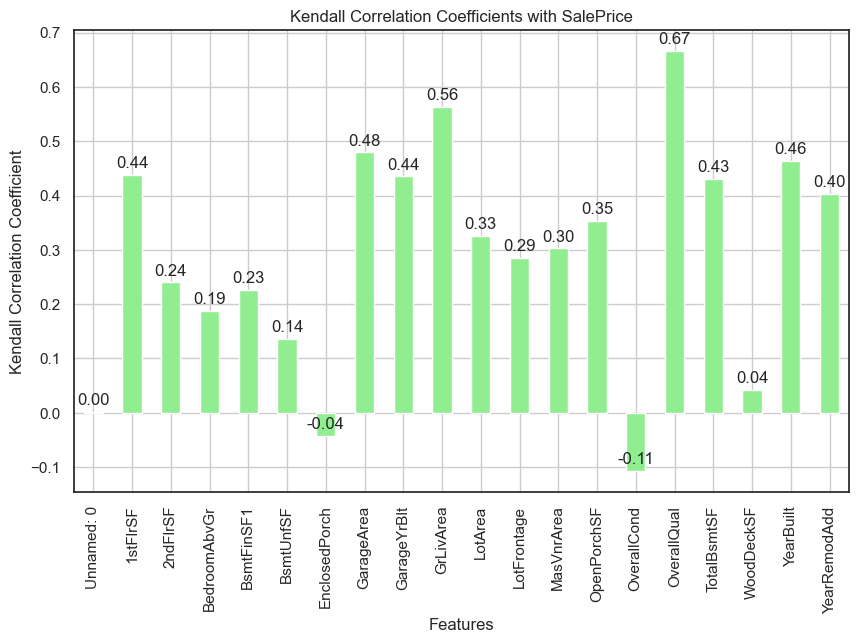

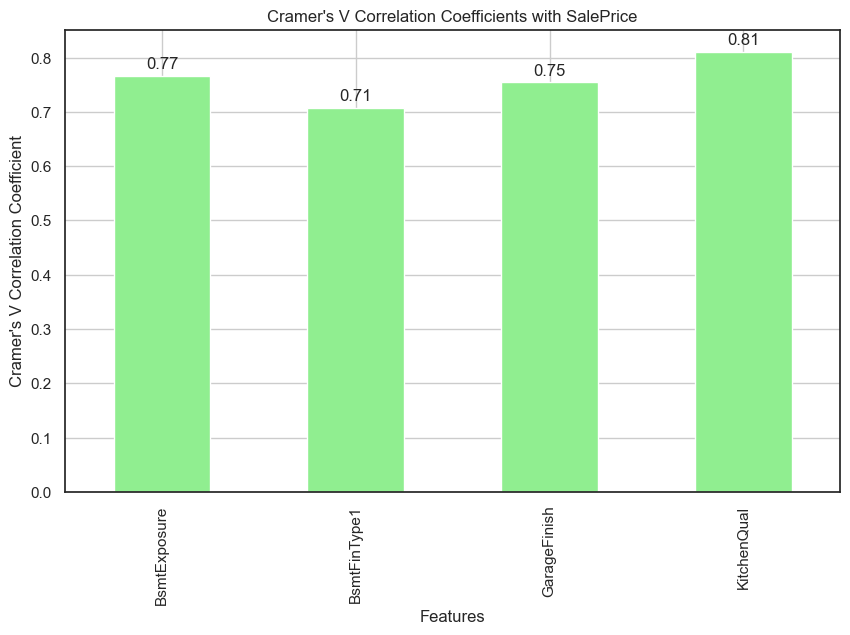

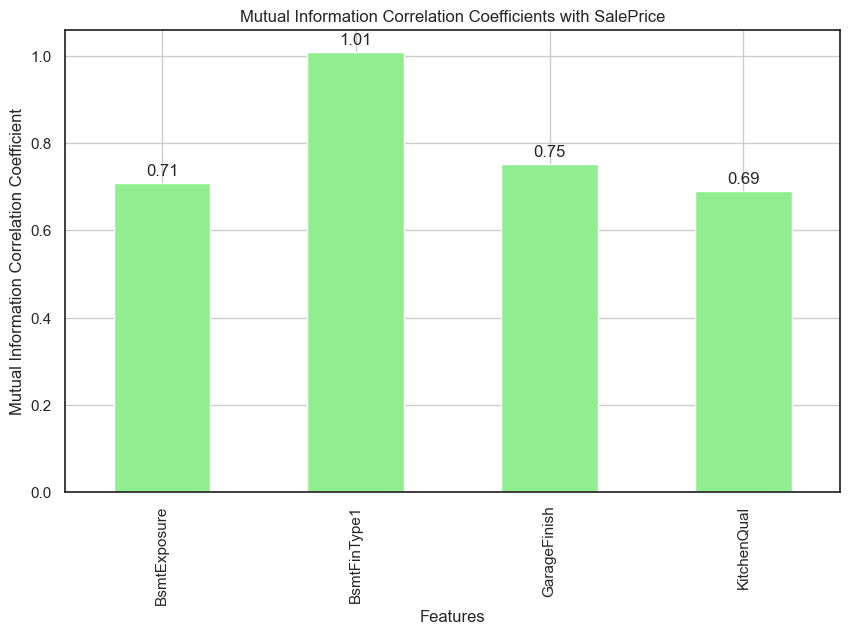

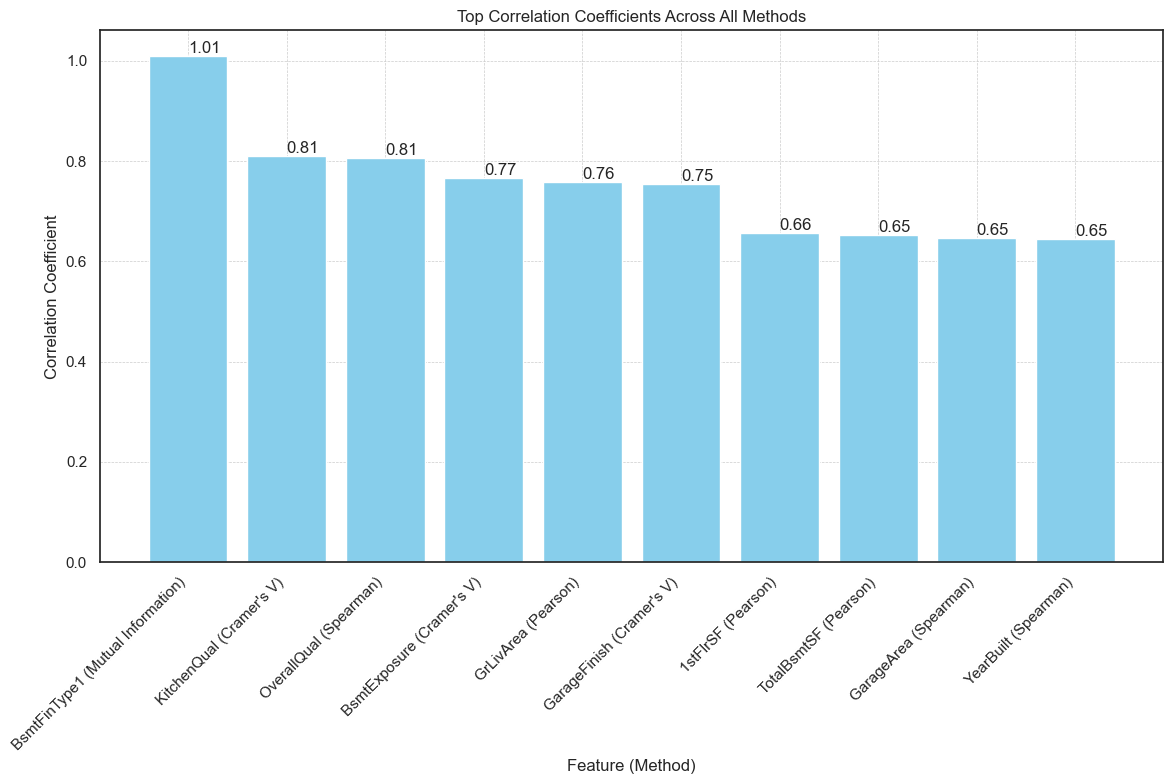

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.metrics import mutual_info_score


def plot_single_correlation(correlation, correlation_type, target):
    """
    Plots a single correlation type.
    correlation: DataFrame with correlation values
    correlation_type: String, name of the correlation type
    target: String, name of the target variable
    """
    plt.figure(figsize=(10, 6))
    ax = correlation.plot(kind='bar', color='lightgreen')
    plt.title(f'{correlation_type} Correlation Coefficients with {target}')
    plt.xlabel('Features')
    plt.ylabel(f'{correlation_type} Correlation Coefficient')
    plt.grid(True)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()


def calculate_numerical_correlations(df, target):
    """Calculates and returns a dictionary of correlation DataFrames for numerical features."""
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    correlations = {}
    for method in ['Pearson', 'Spearman', 'Kendall']:
        corrs = []
        for col in numerical_cols:
            if col != target:
                if method == 'Pearson':
                    corr_value = ss.pearsonr(df[col], df[target])[0]
                elif method == 'Spearman':
                    corr_value = ss.spearmanr(df[col], df[target])[0]
                elif method == 'Kendall':
                    corr_value = ss.kendalltau(df[col], df[target])[0]
                corrs.append(corr_value)
        correlations[method] = pd.Series(corrs, index=[col for col in numerical_cols if col != target])
    return correlations


def calculate_categorical_correlations(df, target):
    """Calculates and returns a dictionary of correlation DataFrames for categorical features."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    correlations = {'Cramer\'s V': {}, 'Mutual Information': {}}
    for col in categorical_cols:
        if col != target:
            table = pd.crosstab(df[col], df[target])
            chi2 = ss.chi2_contingency(table)[0]
            correlations['Cramer\'s V'][col] = np.sqrt(chi2 / (table.sum().sum() * (min(table.shape) - 1)))
            correlations['Mutual Information'][col] = mutual_info_score(df[col], df[target])
    for key in correlations:
        correlations[key] = pd.Series(correlations[key])
    return correlations


def plot_top_correlations(df, target, top_n=10):
    num_corr = calculate_numerical_correlations(df, target)
    cat_corr = calculate_categorical_correlations(df, target)
    all_correlations = {**num_corr, **cat_corr}

    # Plot individual correlation types
    for corr_type, corr_values in all_correlations.items():
        plot_single_correlation(corr_values, corr_type, target)

    # Convert dictionary of Series to DataFrame
    correlation_df = pd.DataFrame(all_correlations)

    # Calculate the maximum correlation value for each feature and determine the corresponding method
    max_values = correlation_df.max(axis=1)
    max_methods = correlation_df.idxmax(axis=1)

    # Create a DataFrame to store these maximum values along with their corresponding methods
    result_df = pd.DataFrame({
        'Feature': max_values.index,
        'Method': max_methods.values,
        'Value': max_values.values
    })

    # Sort the DataFrame by the 'Value' column in descending order to find the highest correlations
    result_df = result_df.sort_values(by='Value', ascending=False).head(top_n)

    # Plotting the results
    plt.figure(figsize=(12, 8))
    bars = plt.bar(result_df['Feature'] + " (" + result_df['Method'] + ")", result_df['Value'], color='skyblue')
    plt.title('Top Correlation Coefficients Across All Methods')
    plt.xlabel('Feature (Method)')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Annotating the bars with their correlation values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", va='bottom')

    plt.tight_layout()
    plt.show()

    return result_df


list_of_top = plot_top_correlations(df_train, 'SalePrice', top_n=10)

We will print out our top 10 correlations:

In [14]:
list_of_top

,Feature,Method,Value
5,BsmtFinType1,Mutual Information,1.010039
12,KitchenQual,Cramer's V,0.810673
18,OverallQual,Spearman,0.805939
3,BsmtExposure,Cramer's V,0.766384
11,GrLivArea,Pearson,0.757815
9,GarageFinish,Cramer's V,0.754536
0,1stFlrSF,Pearson,0.656586
19,TotalBsmtSF,Pearson,0.651793
8,GarageArea,Spearman,0.647494
22,YearBuilt,Spearman,0.645365


We have a list of features we will be investigating:
* BsmtFinType1
* KitchenQual
* OverallQual
* BsmtExposure
* GrLivArea
* GarageFinish
* 1stFlrSF
* TotalBsmtSF
* GarageArea
* YearBuilt

We will convert top features to list and save it in jupyter_notebooks/intern_notebook_information_share.json
This might be handy in the future, less hand typing.

In [15]:
# Converting to list all top features
top_correlations_list_hypothesis_1 = list_of_top.values.tolist()
# Making a list of features + SalePrice, so later it is easier to manage dataframe.
features_list = [item[0] for item in top_correlations_list_hypothesis_1]
features_list.append('SalePrice')

# Importing some extra functions we have created
from extra_funcionality import save_data

# Saving both lists for future reuse
save_data('hypothesis_1_top_correlations', top_correlations_list_hypothesis_1)
save_data('hypothesis_1_features', features_list)

## EDA on selected features

We will create separate dataframe just with selected features + SalePrice

In [16]:
df = df_train[features_list]
df

,BsmtFinType1,KitchenQual,OverallQual,BsmtExposure,GrLivArea,GarageFinish,1stFlrSF,TotalBsmtSF,GarageArea,YearBuilt,SalePrice
809,Unf,TA,5,No,2138,Unf,1075,849,360,1898,106000
608,BLQ,TA,8,Mn,3194,Unf,1940,965,380,1934,359100
1189,Unf,Gd,7,No,1804,Fin,1028,994,442,1999,189000
1039,GLQ,TA,4,Av,630,Unf,630,630,286,1970,80000
1297,GLQ,TA,6,Gd,1072,Fin,1072,547,525,2005,140000
...,...,...,...,...,...,...,...,...,...,...,...
866,Unf,Gd,8,Av,1646,RFn,1646,1638,870,2006,248900
742,Unf,TA,7,No,1349,Unf,1349,1349,539,2000,179000
74,Unf,TA,3,No,1605,Unf,840,840,379,1915,107400
176,GLQ,TA,6,No,2060,Unf,1164,1151,521,1988,211000


We will check how each feature is distributed against the Price, so we can see correlations

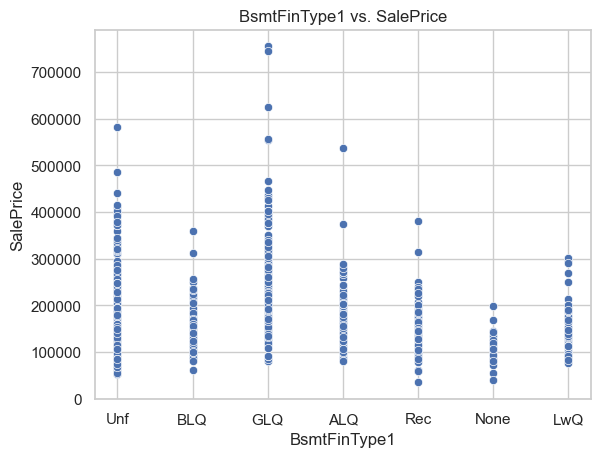

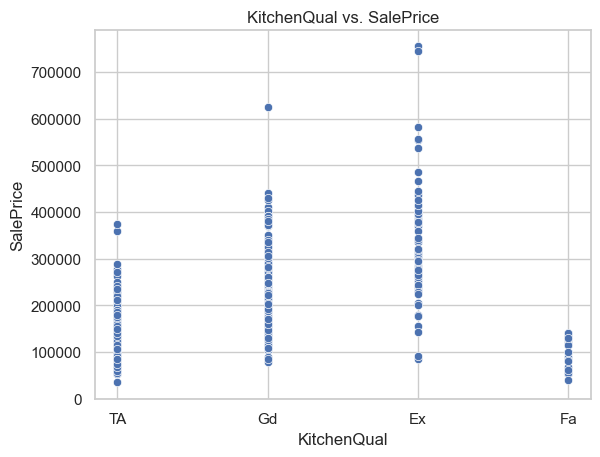

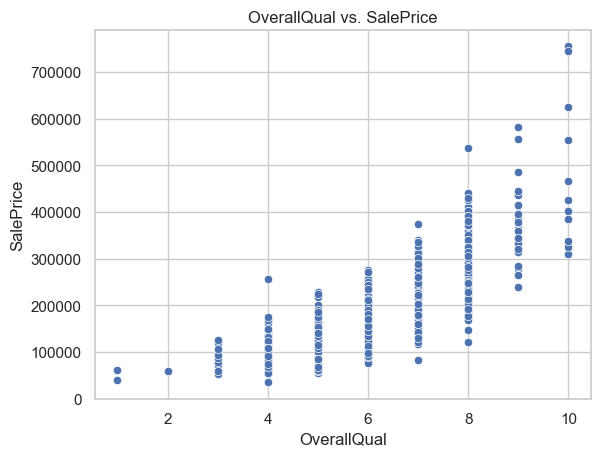

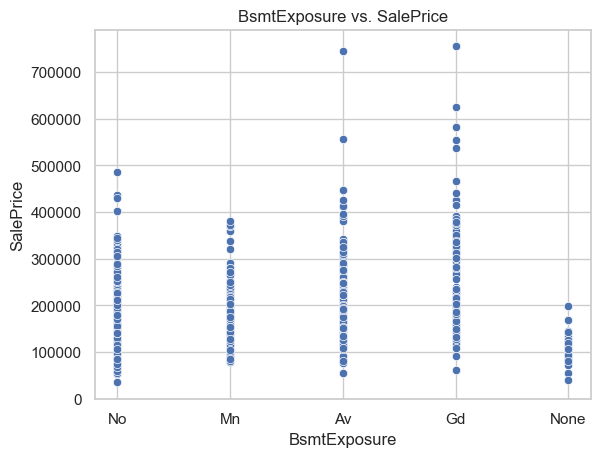

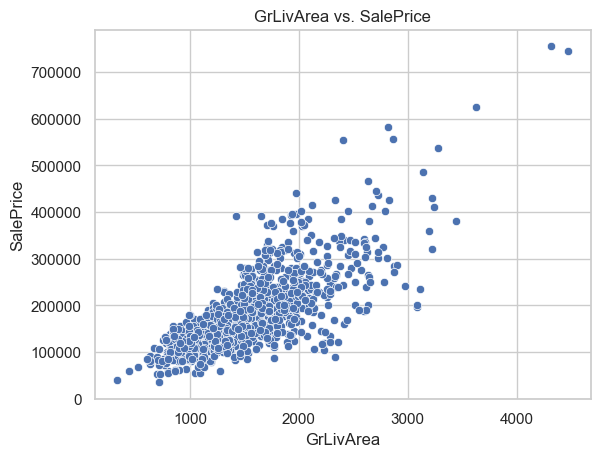

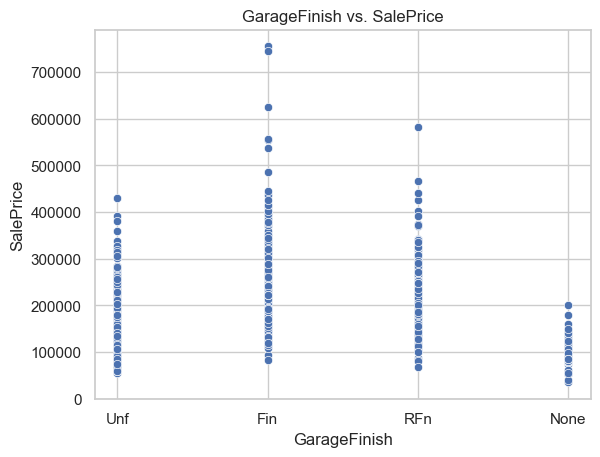

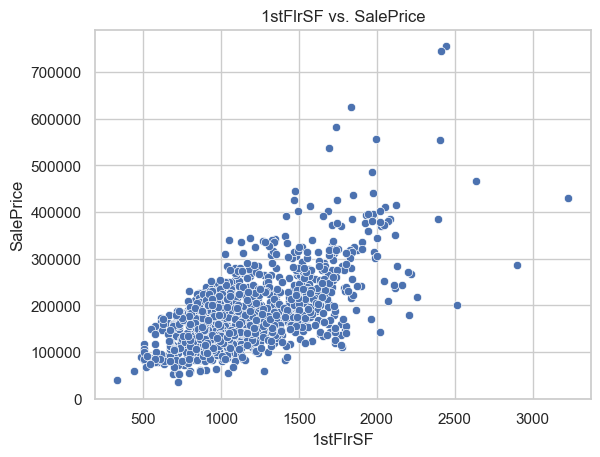

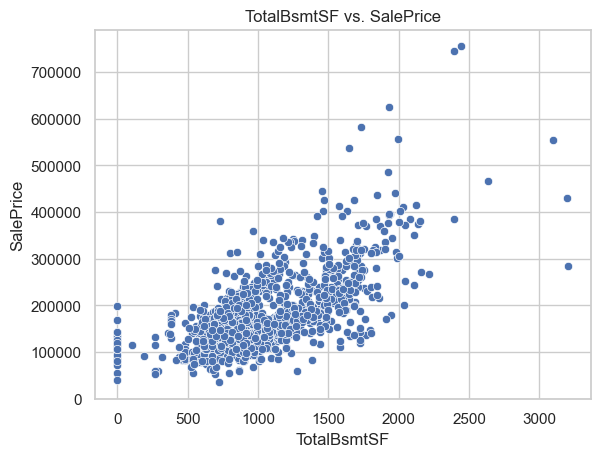

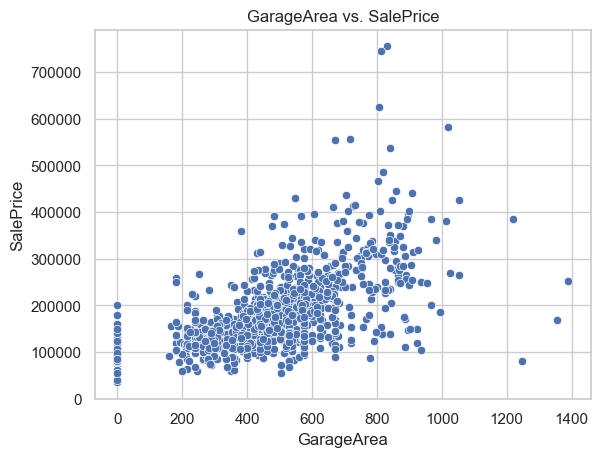

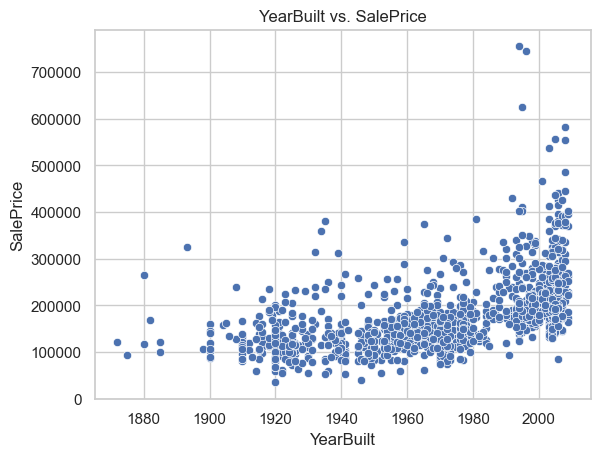

In [17]:
numeric_columns = df.columns

# Set the style
sns.set(style="whitegrid")

# Plot each feature against SalePrice
for column in numeric_columns[:-1]:
    sns.scatterplot(x=column, y='SalePrice', data=df)
    plt.title(f'{column} vs. SalePrice')
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    plt.show()

## Hypothesis - 1

Based on Plots above we can conclude these points:

* BsmtFinType1 - With Basement Quality increasing, house price tends to increase, although there is some high prices in Unfinished category
* KitchenQual - Kitchen Quality is very clear, with its quality going up, price also goes up.
* OverallQual - Overall Quality is most correlated feature from all, and when it increases, SalePrice also increases
* BsmtExposure - If There is basement in building, With better exposure price tends to increase
* GrLivArea - Increasing Ground Living Area SalePrice also increases
* GarageFinish - Just having garage, price increases, and the more it is Finished, the better house price
* 1stFlrSF - Similar to Ground Living Area, when it goes up, SalePrice also increases
* TotalBsmtSF - By increasing Basement we are increasing SalePrice
* GarageArea - When Garage Area goes up, Sale Price also increase. Most of the houses without garages are 150.000 or less
* YearBuilt - By increasing Garage Year Built we are increasing SalePrice, but it looks more exponential after 1980 ish...



## Next is Feature Engineering